# DATASET

In [15]:
import numpy as np
import tensorflow_datasets as tfds
import tqdm
from PIL import Image
from IPython import display

import mujoco,sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../package/')
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')

from mujoco_parser import *
from transformation import *
from slider import *
from utility import *
from utils import *

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo:[%s]"%(mujoco.__version__))

MuJoCo:[3.1.6]


In [16]:
display_key = 'hand_color_image'

ds = tfds.load("conq_hose_manipulation", split="val", data_dir="gs://gresearch/robotics")

In [17]:
images = []
for episode in ds.shuffle(10, seed=2).take(1):
  for i, step in enumerate(episode["steps"]):
    images.append(
      Image.fromarray(
        np.concatenate((
              step["observation"]["frontleft_fisheye_image"].numpy(),
              step["observation"]["frontright_fisheye_image"].numpy(),
        ), axis=1)
      )
    )
import os
from PIL import Image
import numpy as np
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

from moviepy import *

frames = [np.array(img.convert('RGB')) for img in images]
clip = ImageSequenceClip(frames, fps=3)
clip.write_videofile("output.mp4", codec='libx264', audio=False)

2025-02-06 14:50:38.174019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:81: Filling up shuffle buffer (this may take a while): 6 of 10
2025-02-06 14:50:40.046284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-02-06 14:50:41.080856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MoviePy - Building video output.mp4.
MoviePy - Writing video output.mp4



MoviePy - Done !
MoviePy - video ready output.mp4


In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def arr2image(array):
    """
    Displays a NumPy array (h, w, c) as an image.
    """
    # Check the array shape and type
    if len(array.shape) != 3 or array.shape[2] not in [3, 4]:
        raise ValueError("Input array must have shape (h, w, c) with c=3 (RGB) or c=4 (RGBA).")
    
    # Display the image using matplotlib
    plt.imshow(array)
    plt.axis('off')  # Turn off axis
    plt.show()

# EPISODE

In [19]:
iter_steps = iter(episode['steps'])
states = [eef['observation']['state'] for eef in iter_steps]

iter_steps = iter(episode['steps'])
actions = [action['action'] for action in iter_steps]

# ENV

In [20]:
xml_path = '../mujoco_menagerie/boston_dynamics_spot/scene_arm.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=False)

# CONTROL

In [19]:
# Visualize environment with initial pose from trajectory
env.init_viewer(
    title='Tabletop',
    transparent=False,
    azimuth=133,
    distance=3.5,
    elevation=-42.4,
    lookat=(-0.06,0.07,0.31),
)

joint_names = env.joint_names

env.reset()

while env.is_viewer_alive():
  env.step()
  if env.loop_every(tick_every=10):
    # env.plot_T(
    #     T=env.get_T_body(body_name='base'),
    #     axis_len=0.5,print_xyz=False)
    
    # env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
    # env.plot_contact_info(
    #     r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)

    env.render()

env.close_viewer()

In [41]:
sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,255],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

# Don't Know Why.....
# q0 = np.array([0, -1, 0, 1, 6, 1.7, 0])

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[0]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos, #np.append(np.append(qpos,xyzrpyg[6]),xyzrpyg[6]),s
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

Done.


In [9]:
sliders = MultiSliderClass( # Slider for joint control
    n_slider      = 8,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4', 'Joint 5', 'Joint 6', 'Joint 7', 'Gripper'],
    slider_mins   = np.degrees(env.joint_ranges[:,0]).tolist() + [0], # Convert joint ranges from radians to degrees
    slider_maxs   = np.degrees(env.joint_ranges[:,1]).tolist() + [255],
    slider_vals   = [0, 0, 0, 0, 0, 0, 0, 0],
    resolutions   = [(max-min)/50 for min,max in zip(np.degrees(env.joint_ranges[:,0]).tolist() + [0], 
                                                    np.degrees(env.joint_ranges[:,1]).tolist() + [255])],
    verbose       = False,
)

joint_names = env.joint_names

# q0 = np.zeros(len(joint_names), dtype=float)
q0 = q_traj[0]

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)
env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position

# Loop
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    joint_values = sliders.get_slider_values()
    
    # Convert degrees to radians for joint angles
    qpos = np.radians(joint_values[:-1])
    
    env.step( # dynamic update
        ctrl        = qpos, # Last value is gripper
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec'%(env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print ("Done.")

2025-01-25 19:53:20.687 python[27790:1498132] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-25 19:53:20.687 python[27790:1498132] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


2025-01-25 19:53:25.040 python[27790:1498132] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


# Trajectory

### 1) genration

In [8]:
joint_names = ['arm_sh0', 'arm_sh1', 'arm_el0', 'arm_el1', 'arm_wr0', 'arm_wr1', 'arm_f1x']
q0 = np.array(joint_states[0])

q_traj = []

q_ik_init = q0.copy()
for ik_target in eef_states:
    # temp = quat2rpy(ik_target[3:].numpy())
    # rot_target = rpy2r(temp)

    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = ik_target[:3], # Convert cm to inches
        R_trgt             = rpy2r(ik_target[3:]),
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )

    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    # print(ik_err, ik_target[:3], rot_target)
    q_traj.append(qpos)

NameError: name 'joint_states' is not defined

### 2) Comparing

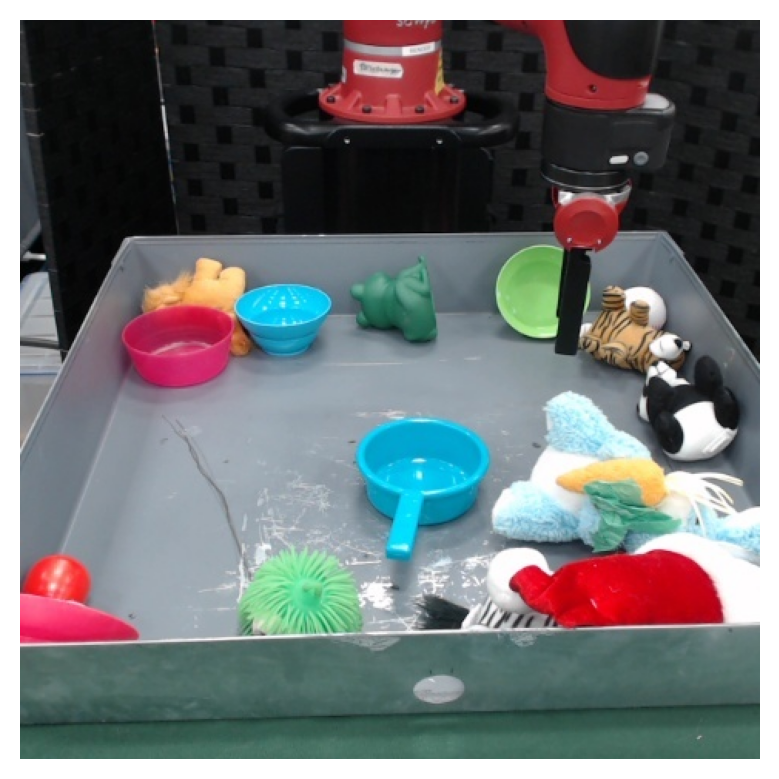

2025-01-24 23:48:48.555 python[25897:1411209] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-24 23:48:48.555 python[25897:1411209] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Done.


2025-01-24 23:49:52.896 python[25897:1411209] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [8]:
# G -> B -> R

idx = -1
assert idx < len(frames)

sliders = MultiSliderClass( # Slider for EE control
    n_slider      = 7,
    title         = 'Sliders for [%s] Control'%(env.name),
    window_width  = 450,
    window_height = 300,
    x_offset      = 0,
    y_offset      = 100,
    slider_width  = 300,
    label_texts   = ['X','Y','Z','Roll-deg','Pitch-deg','Yaw-deg','Gripper'],
    slider_mins   = [-1,-1,0,-180,-180,-180,0],
    slider_maxs   = [+1,+1,1.2,+180,+180,+180,2],
    slider_vals   = [0,0,0,0,0,0,0],
    resolutions   = [0.02,0.02,0.02,3.6,3.6,3.6,0.04], # range/50
    verbose       = False,
)

joint_names = env.joint_names

env.reset(step=True)

q0 = q_traj[idx]
env.forward(q=q0,joint_names=joint_names) # initial position

p0 = env.get_p_body(body_name='tcp_link')
R0 = env.get_R_body(body_name='tcp_link')

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

arr2image(frames[idx])

# Loop
q_ik_init = q0.copy()
while env.is_viewer_alive():
    
    # Update
    sliders.update() # update slider
    xyzrpyg = sliders.get_slider_values()
    qpos,ik_err_stack,ik_info = solve_ik(
        env                = env,
        joint_names_for_ik = joint_names,
        body_name_trgt     = 'tcp_link',
        q_init             = q_ik_init,
        p_trgt             = xyzrpyg[:3]+p0,
        R_trgt             = rpy_deg2r(xyzrpyg[3:6])@R0,
        max_ik_tick        = 500,
        ik_stepsize        = 1.0,
        ik_eps             = 1e-2,
        ik_th              = np.radians(5.0),
        render             = False,
        verbose_warning    = False,
    )
    
    ik_err = np.abs(ik_err_stack).max() # IK error
    if ik_err < 1e-2: q_ik_init = qpos.copy()
    else: q_ik_init = q0.copy()
    
    env.step( # dynamic update
        ctrl        = qpos,
        joint_names = joint_names
    )
    
    # Render 
    if env.loop_every(tick_every=10):
        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'time:[%.2f]sec ik_err:[%.3f]'%(env.get_sim_time(),ik_err))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(
            r_arrow=0.005,h_arrow=0.1,rgba_contact=(1,0,0,0.5),plot_sphere=False)
        plot_ik_info(env=env,ik_info=ik_info)
        
        env.render()

# Close
env.close_viewer()
sliders.close()
print("Done.")  

# Trajectory Reappearance

In [13]:
joint_names = env.joint_names
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
    
# Loop
q_ik_init = q0.copy()
qpos = q_traj[0]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)

    # Render 
    if env.loop_every(HZ=0.1):
        if idx < len(q_traj)-1:
            idx += 1
        else: idx = 0

        qpos = q_traj[idx]

        env.plot_T(
            T=env.get_T_body(body_name='base'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='base')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

2025-01-27 23:42:26.942 python[38912:2470069] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-27 23:42:26.942 python[38912:2470069] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-01-27 23:42:49.670 python[38912:2470069] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


Done.


In [22]:
joint_names = env.joint_names
q0 = np.zeros(len(joint_names), dtype=float)

env.init_viewer(
    title       = 'Tabletop',
    transparent = False,
    azimuth     = 133,
    distance    = 3.5,
    elevation   = -42.4,
    lookat      = (-0.06,0.07,0.31),
)

env.reset() # reset
env.forward(q=q0,joint_names=joint_names) # initial position
eef_state = [np.zeros_like(joint_names) for _ in range(len(states))]

# Loop
q_ik_init = q0.copy()
qpos = states[0][:20]
idx = 0

while env.is_viewer_alive():
    env.forward(q=qpos,joint_names=joint_names)
    eef_state[idx] = [env.get_p_body(body_name='tcp_link'), r2rpy(env.get_R_body(body_name='tcp_link'))]

    # Render 
    if env.loop_every(HZ=0.2):

        if idx < len(states)-1:
            idx += 1
        else: idx = 0

        qpos = states[idx][:20]

        env.plot_T(
            T=env.get_T_body(body_name='body'),
            axis_len=0.5,print_xyz=False)
        env.plot_text(
            p=env.get_p_body(body_name='body')+np.array([0,0,0.5]),
            label = 'tick:[%d]time:[%.2f]'%(idx, env.get_sim_time()))
        env.plot_body_T(body_name='tcp_link',axis_len=0.1,axis_width=0.005)
        
        env.render()

# Close
env.close_viewer()
print ("Done.")

Done.


# Reverse Engineering

In [13]:
print(states[0][:20])
print(states[0][20:40])
print(states[0][40:])

tf.Tensor(
[ 1.1654378e-01  6.5102679e-01 -1.4305722e+00 -1.3726337e-01
  5.8115846e-01 -1.3841432e+00  1.3055266e-01  6.2586212e-01
 -1.3866068e+00 -1.4771685e-01  6.1111605e-01 -1.3563386e+00
  6.8192482e-03 -1.4889528e+00  0.0000000e+00  2.5382302e+00
  8.1586838e-04 -1.0573137e+00 -6.0744286e-03 -1.5696775e+00], shape=(20,), dtype=float32)
tf.Tensor(
[ 0.00236467 -0.00672597 -0.03102343 -0.01326003 -0.00974649 -0.02748489
 -0.00110426 -0.016899   -0.00481877 -0.00504524  0.00538139 -0.01669127
 -0.00403552  0.00250951  0.          0.01030492  0.00796259  0.00324367
 -0.01880039 -0.00921902], shape=(20,), dtype=float32)
tf.Tensor(
[ 3.4703157e-04  4.4639834e-04 -1.5111049e-04  7.3998328e-04
 -3.8800540e-04  9.1306801e-04  0.0000000e+00  7.1141563e-02
  4.1993898e-03 -5.0984746e-01  3.5879582e-01  2.2841547e-01
 -5.2712446e-01  1.0000000e+00  3.8442519e-01 -2.4010964e-01
 -5.2928507e-01  1.0000000e+00 -2.3523828e-01  2.3691210e-01
 -5.3324568e-01  1.0000000e+00 -2.3551656e-01 -2.4691

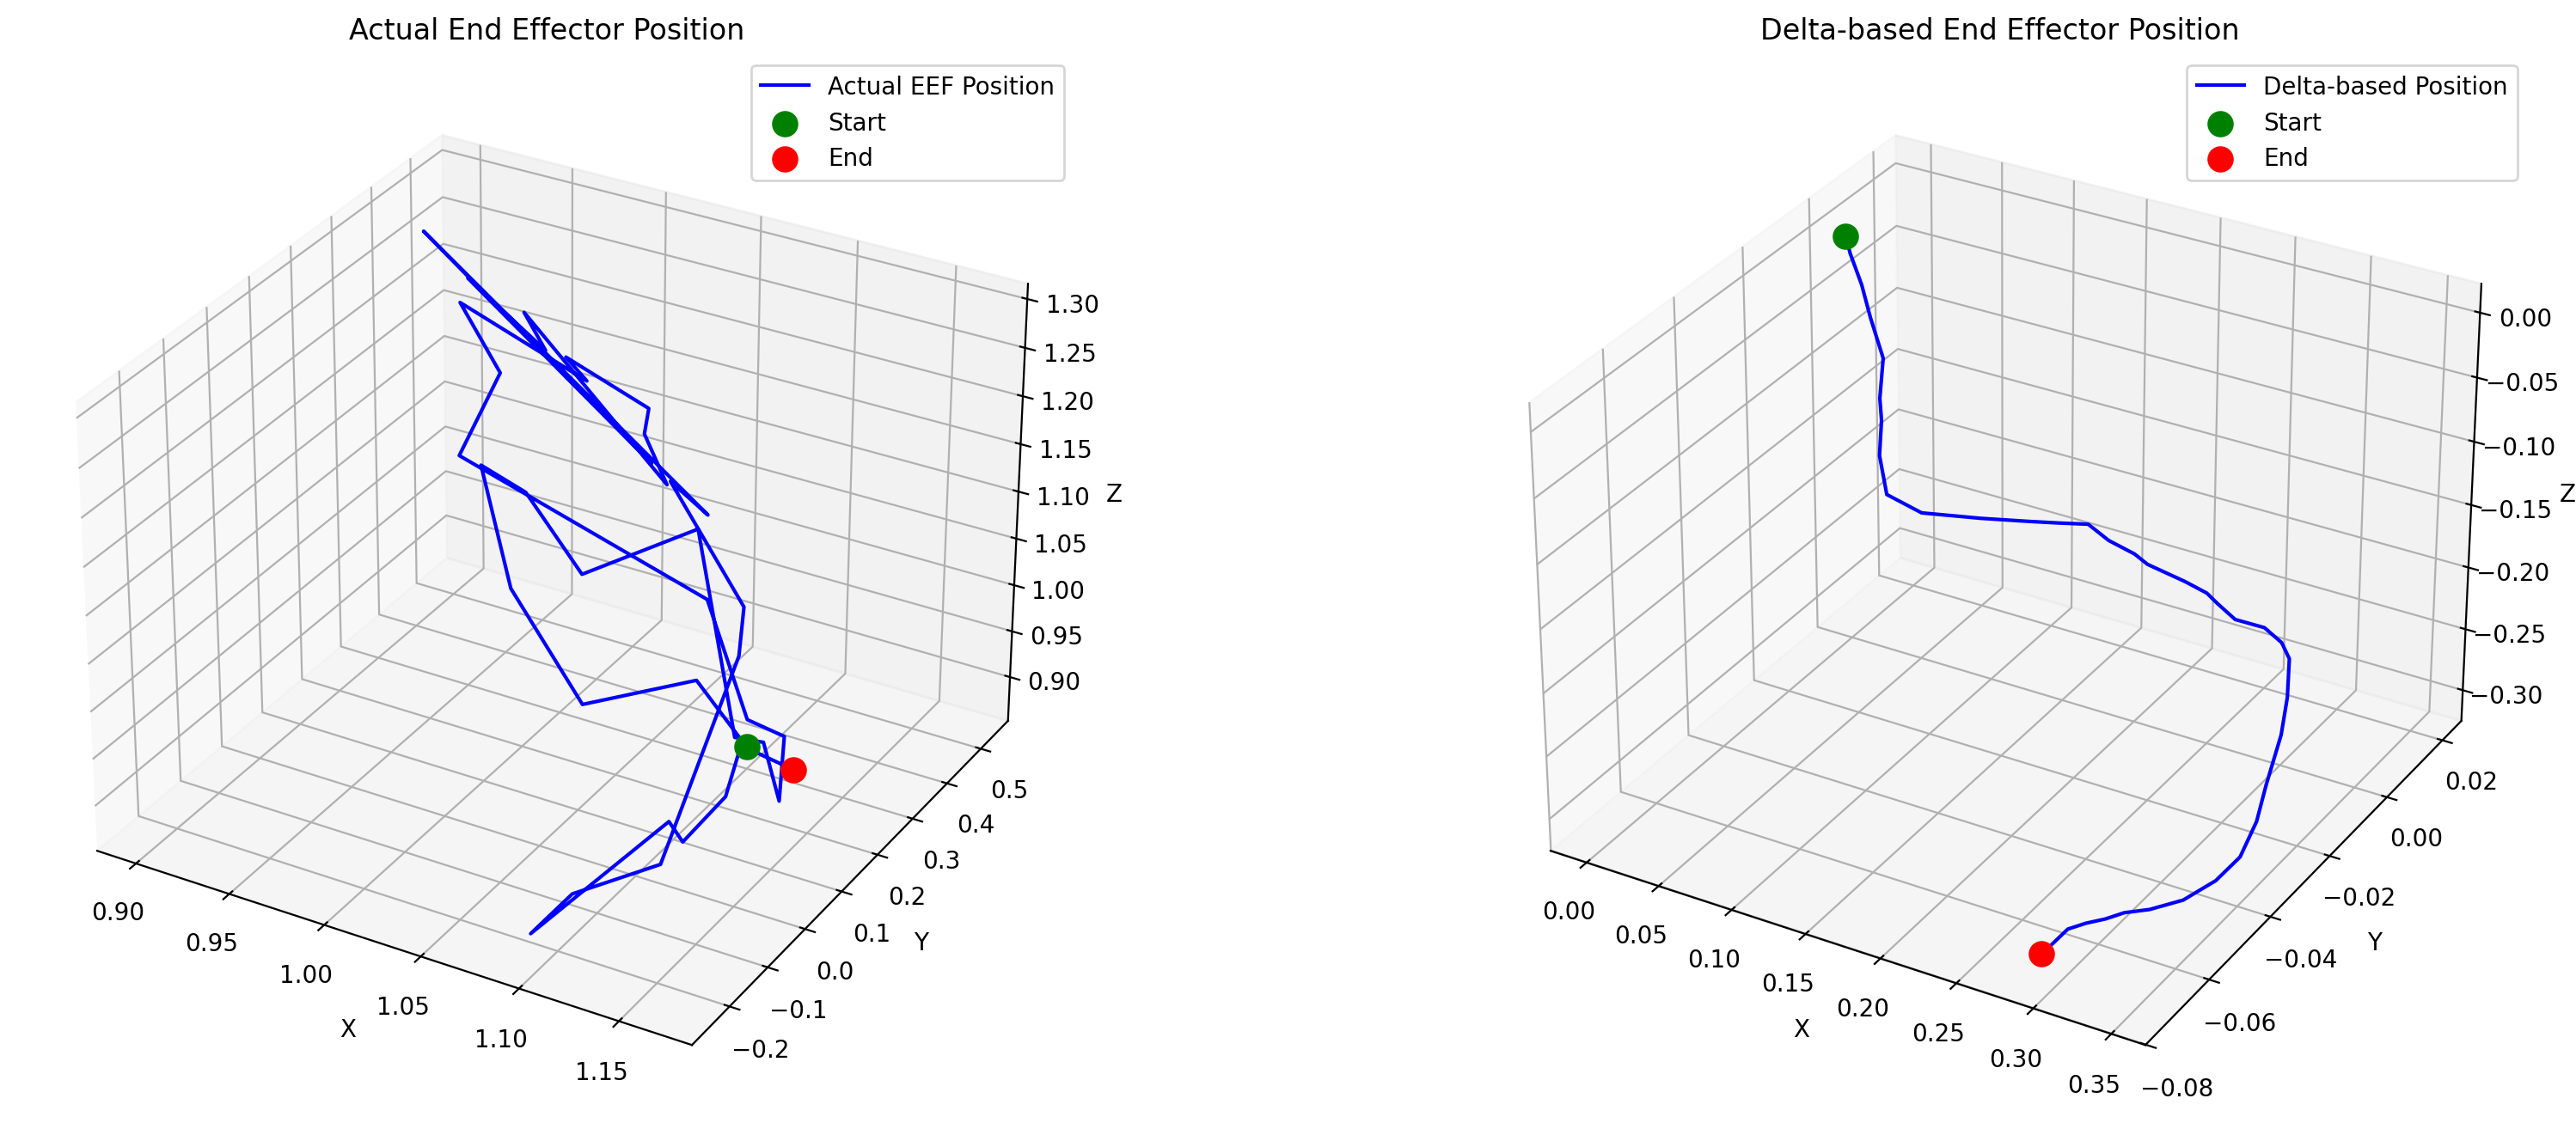

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create figure with 2 subplots
fig = plt.figure(figsize=(20, 8))

# First subplot - Actual EEF positions
ax1 = fig.add_subplot(121, projection='3d')

# Extract actual positions from eef_state
actual_positions = np.array([state[0] for state in eef_state])

# Plot actual position trajectory
ax1.plot(actual_positions[:,0], actual_positions[:,1], actual_positions[:,2], 'b-', label='Actual EEF Position')
ax1.scatter(actual_positions[0,0], actual_positions[0,1], actual_positions[0,2], c='g', marker='o', s=100, label='Start')
ax1.scatter(actual_positions[-1,0], actual_positions[-1,1], actual_positions[-1,2], c='r', marker='o', s=100, label='End')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Actual End Effector Position')
ax1.legend()

# Second subplot - Accumulated delta positions
ax2 = fig.add_subplot(122, projection='3d')

# Initialize and accumulate delta positions
positions = []
current_pos = np.array([0., 0., 0.])
for action in actions:
    delta_xyz = action[:3]  # First 3 elements are position deltas
    current_pos = current_pos + delta_xyz
    positions.append(current_pos)

positions = np.array(positions)

# Plot accumulated delta trajectory
ax2.plot(positions[:,0], positions[:,1], positions[:,2], 'b-', label='Delta-based Position')
ax2.scatter(positions[0,0], positions[0,1], positions[0,2], c='g', marker='o', s=100, label='Start')
ax2.scatter(positions[-1,0], positions[-1,1], positions[-1,2], c='r', marker='o', s=100, label='End')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Delta-based End Effector Position')
ax2.legend()

plt.show()